# Implementation of pixel-flipping algorithm

https://bowenroom.github.io/myBlog/pytorch/fastai2/2020/06/01/torch-unfold.html

In [1]:
from torchvision import transforms
import torch
import numpy
from lrp import image

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224, 224)),
  transforms.ConvertImageDtype(torch.float),
  transforms.Normalize(mean, std)
])

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

# Image is in RGB mode with range [0,1]
img: numpy.array = image.load_normalized_img('../data/castle2.jpg')
X = transform(img)
# Simulate batch by adding a new dimension
X = torch.unsqueeze(X, 0)
X=X[0]
print(X.shape)

torch.Size([3, 224, 224])


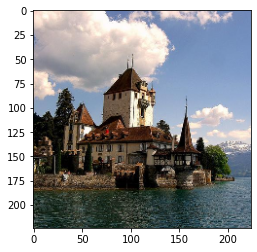

In [2]:
from matplotlib import pyplot as plt
plt.imshow(inv_normalize(X).numpy().transpose((1, 2, 0)))

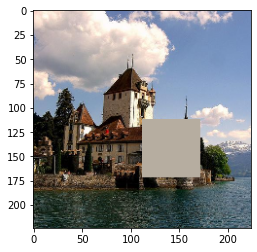

In [3]:
erased_x = transforms.functional.erase(img=X, i=112, j=112, h=60, w=60, v=1)
plt.imshow(inv_normalize(erased_x).numpy().transpose((1, 2, 0)))